# False discovery of cell type-specific DEGs in independently, identically simulated cohorts

Here I investigate the question: does CIBERSORTx infer differential expression when none truly exists?

CIBERSORTx infers:
1. Cell type-specific expression on average for an entire cohort
   - in other words, a "representative" cell type GEP for each cell type, given several bulk RNA-seq profiles
2. Cell type-specific expression for every sample in a cohort

Methods:
1. I create two cohorts of in silico-generated bulk RNA-seq
   - I generate these identically
     - same settings (e.g. # of single cells to sample per sample-specific cell type GEP)
     - same cell type fractions per sample (using estimated cell type fractions from TCGA SKCM mets)
   - The only difference is random sampling of single cell data
2. I compare the two cohorts
   - DEG analysis at a sample level
   - DEG analysis 

# Imports and setup

In [ ]:
import logging
import warnings

import dask.dataframe as dd
import helpers
import numpy as np
import pandas as pd
import scipy.stats

In [ ]:
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")

helpers.logging.configure_logging()

# True DEG analysis

What does DEG analysis look like for the in silico generated cohorts?

A priori, no genes are differentially expressed... But checking differential expression gives us a baseline of what to expect in terms of false discovery of DEGs.

## Bulk-level DEG analysis of true expression
    

In [ ]:
def compute_stats(group):
    logger.debug("processing group %s", group.name)
    assert len(group) == 2, group.shape
    group = group.set_index("cohort_id").loc[["0", "1"]]
    group = group.filter(regex="^TCGA", axis="columns")
    data_0, data_1 = group.values[0], group.values[1]
    return pd.Series(
        dict(
            log2_fold_change=np.log2(data_1.mean() / data_0.mean()),
            pval_ttest=scipy.stats.ttest_ind(data_0, data_1).pvalue,
            pval_mannwhitneyu=scipy.stats.mannwhitneyu(data_0, data_1).pvalue,
        )
    )


df = pd.read_csv("gs://liulab/deconv/analysis/evaluating_cibersortx/bulk_deg_stats.csv")

fig = px.scatter(
    df,
    x="log2_fold_change",
    y="-log10_pval_mwu",
    color="significant_bh_fdr=0.1",
)
fig.update_layout(
    title="Differential expression in independent, identically-generated in silico cohorts",
    xaxis_title=r"$\log_2 \text{FC}$",
    yaxis_title=r"$\log_10 \text{MWU p-value}$",
    legend_title="Significant?",
    # font=dict(family="Courier New, monospace", size=18, color="RebeccaPurple"),
)
fig.update_traces(marker=dict(size=5))
fig.show(renderer="png", width=1000, height=800, scale=2)

## Cell type-level DEG analysis of true expression

# DEG analysis of CIBERSORTx inferred cell type-specific gene expression

Does CIBERSORTx infer more DEG than what actually exists in the data?

## Cell type-level DEG analysis of CIBERSORTx-inferred expression

# appendix

Notebook content to go here...
- Volcano plot of differential expression between the two cohorts

From CIBERSORTx Supplementary Figures:
- 9\. Analysis of primary tumor specimens with  high-resolution CIBERSORTx.
  - 9.2. NSCLC.
    > Following high-resolution purification, cell type-specific DEGs were identified between LUAD and LUSC tumor samples by a two-sided unequal variance t test applied to log2 adjusted expression data.
    
    > To filter DEGs for significance, we used an empirically derived threshold (log2 fold change >0.1) that maximized the sensitivity and specificity of DEG recovery in simulated melanoma tumors (see ‘Simulated melanoma tumors with eight cell types’ and Supplementary Fig. 10) coupled with a Q value threshold (Benjamini-Hochberg) of <0.5 for additional stringency.


In [1]:
import logging
import warnings

import dask.dataframe as dd
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats

import helpers

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")

# helpers.logging.configure_logging()
udp_handler = logging.handlers.DatagramHandler("localhost", 12000)
udp_handler.setLevel("DEBUG")
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(helpers.logging.formatter)
stream_handler.setLevel("INFO")

logging.getLogger().handlers = [udp_handler, stream_handler]

In [3]:
logger.debug("debug")
logger.info("info")
logger.warning("warn")

2022-08-22 16:18:25,102 10349/MainThread __main__ INFO
info
2022-08-22 16:18:25,103 10349/MainThread __main__ WARNING
warn


## Differential expression at a sample level

In [4]:
uri = "gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/*/outdir/CIBERSORTxGEP_NA_GEPs.txt"

df = (
    dd.read_csv(
        uri,
        sep="\t",
        include_path_column=True,
        dtype={"NK": "float64", "T CD4": "float64", "T CD8": "float64"},
    )
    # .sample(frac=0.001)
    # .dropna()
    .compute()
)
df[["cohort_id"]] = df["path"].str.extract(".*/(.*)/outdir/CIBERSORTxGEP_NA_GEPs.txt")
df = df.drop(columns="path")
df = df.set_index(["cohort_id", "GeneSymbol"])


def compute_stats(group):
    logger.debug("processing gene symbol %s", group.name)
    assert len(group) == 2, group.shape
    # group = group.filter(regex="^TCGA", axis="columns")
    data_0, data_1 = group.loc["0"].values[0], group.loc["1"].values[0]
    return pd.Series(
        dict(
            log2_fold_change=np.log2(data_1.mean() / data_0.mean()),
            pval_ttest=scipy.stats.ttest_ind(data_0, data_1).pvalue,
            pval_mannwhitneyu=scipy.stats.mannwhitneyu(data_0, data_1).pvalue,
        )
    )

In [5]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = df.groupby("GeneSymbol").apply(compute_stats)

CPU times: user 16.8 s, sys: 929 ms, total: 17.7 s
Wall time: 22.5 s


In [6]:
results["-log10_pval_mannwhitneyu"] = -np.log10(results["pval_mannwhitneyu"])

In [7]:
results

,log2_fold_change,pval_ttest,pval_mannwhitneyu,-log10_pval_mannwhitneyu
GeneSymbol,,,,
A1BG,0.252206,0.843204,0.951661,0.021518
A1BG.AS1,1.117303,0.443695,0.586672,0.231605
A1CF,0.006709,0.995379,0.927117,0.032865
A2M,-0.054066,0.973451,0.654869,0.183845
A2M.AS1,-0.134957,0.915558,1.000000,-0.000000
...,...,...,...,...
ZYG11A,-0.814666,0.501671,0.382955,0.416852
ZYG11B,-0.479500,0.603361,0.637154,0.195756
ZYX,0.187039,0.887112,1.000000,-0.000000


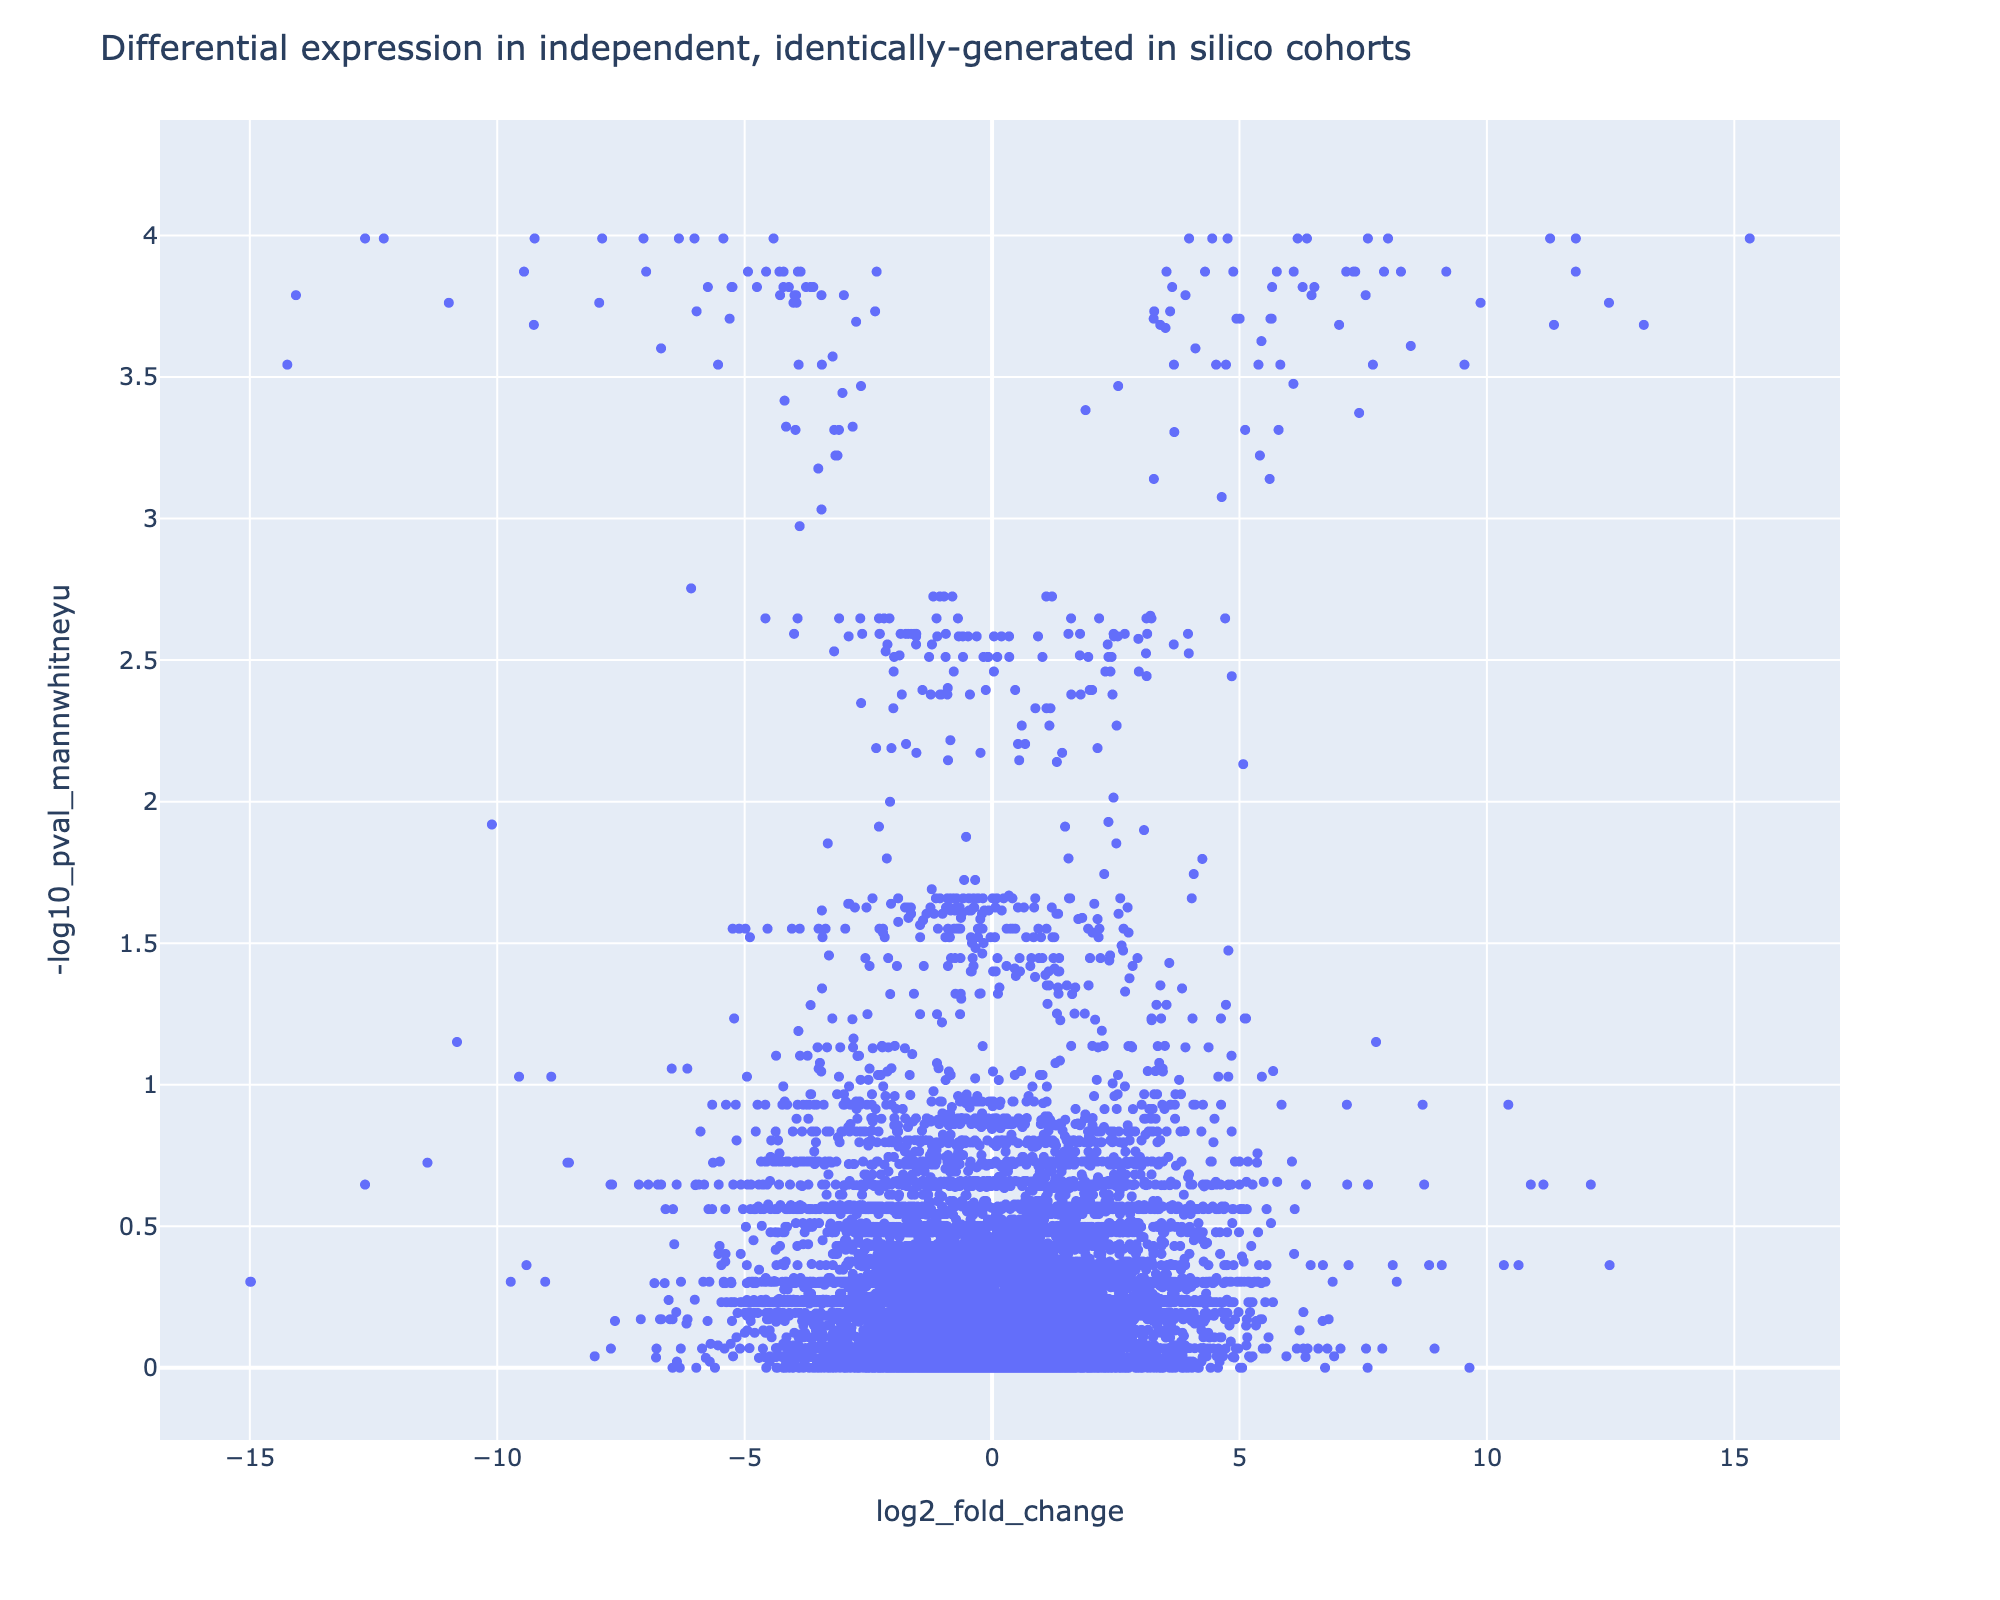

In [8]:
fig = px.scatter(
    results.reset_index(),
    x="log2_fold_change",
    y="-log10_pval_mannwhitneyu",
)
fig.update_layout(
    title="Differential expression in independent, identically-generated in silico cohorts",
)
fig.update_traces(marker=dict(size=5))
fig.show(renderer="png", width=1000, height=800, scale=2)

## Differential expression at a cell type level

In [ ]:
uri = "gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/*/outdir/CIBERSORTxHiRes_NA_*_Window36.txt"
# fmt: off
df = (
    dd.read_csv(uri, sep="\t", include_path_column=True)
    # .sample(frac=0.001)
    # .dropna()
    .compute()
)
# fmt: on
df[["cohort_id", "cell_type"]] = df["path"].str.extract(
    ".*/(.*)/outdir/CIBERSORTxHiRes_NA_(.*)_Window36.txt"
)

In [ ]:
def compute_stats(group):
    logger.debug("processing group %s", group.name)
    assert len(group) == 2, group.shape
    group = group.set_index("cohort_id").loc[["0", "1"]]
    group = group.filter(regex="^TCGA", axis="columns")
    data_0, data_1 = group.values[0], group.values[1]
    return pd.Series(
        dict(
            log2_fold_change=np.log2(data_1.mean() / data_0.mean()),
            pval_ttest=scipy.stats.ttest_ind(data_0, data_1).pvalue,
            pval_mannwhitneyu=scipy.stats.mannwhitneyu(data_0, data_1).pvalue,
        )
    )


def run(df):
    # logger.info("filtering gene names")
    # df = df[df["GeneSymbol"].str.contains("HLA")]
    logger.info("filtering groups with NaN")
    df = df.groupby(["cell_type", "GeneSymbol"]).filter(
        lambda group: not group.isna().any(axis=None)
    )
    grouped = df.groupby(["cell_type", "GeneSymbol"])
    logger.info("applying across %d groups", len(grouped))
    return grouped.apply(compute_stats)

In [22]:
%%time
# logger.setLevel("INFO")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = run(df)

2022-08-19 22:41:36,911 32243/MainThread __main__ INFO
filtering groups with NaN
2022-08-19 22:44:22,241 32243/MainThread __main__ INFO
applying across 93520 groups


In [10]:
results["-log10_pval_mannwhitneyu"] = -np.log10(results["pval_mannwhitneyu"])

In [11]:
results

,log2_fold_change,pval_ttest,pval_mannwhitneyu,-log10_pval_mannwhitneyu
GeneSymbol,,,,
A1BG,0.252206,0.843204,0.951661,0.021518
A1BG.AS1,1.117303,0.443695,0.586672,0.231605
A1CF,0.006709,0.995379,0.927117,0.032865
A2M,-0.054066,0.973451,0.654869,0.183845
A2M.AS1,-0.134957,0.915558,1.000000,-0.000000
...,...,...,...,...
ZYG11A,-0.814666,0.501671,0.382955,0.416852
ZYG11B,-0.479500,0.603361,0.637154,0.195756
ZYX,0.187039,0.887112,1.000000,-0.000000


In [ ]:
results["-log10_pval_mannwhitneyu"] = -np.log10(results["pval_mannwhitneyu"])

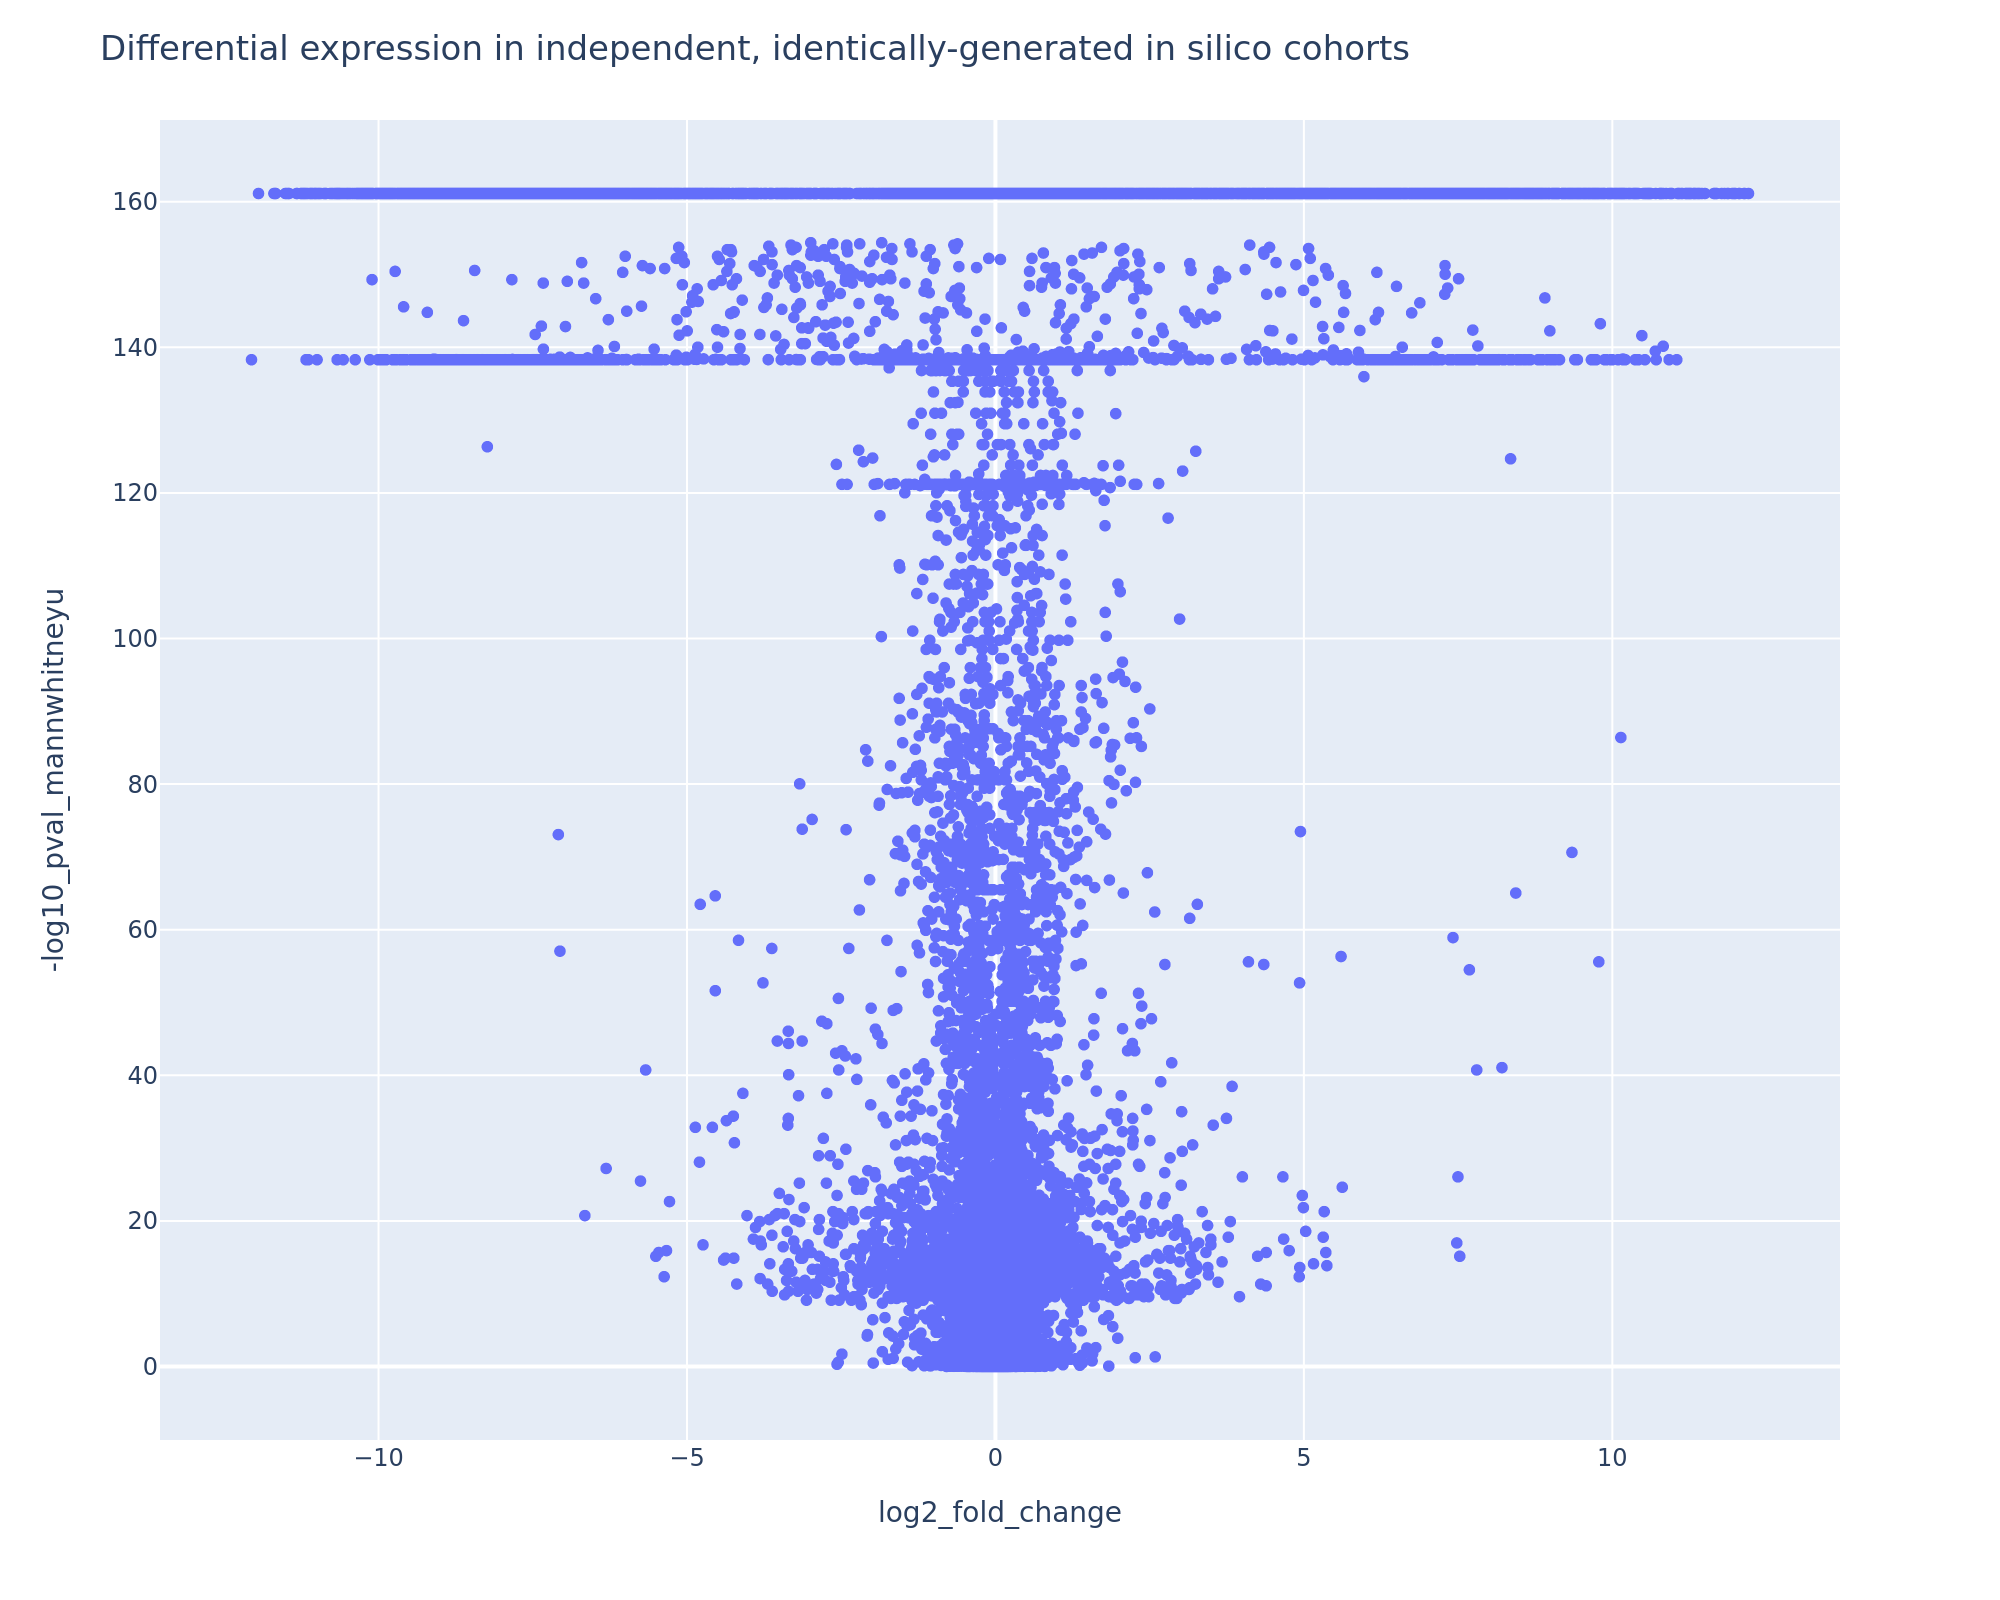

In [65]:
fig = px.scatter(
    results.reset_index(),
    x="log2_fold_change",
    y="-log10_pval_mannwhitneyu",
)
fig.update_layout(
    title="Differential expression in independent, identically-generated in silico cohorts",
)
fig.show(renderer="png", width=1000, height=800, scale=2)

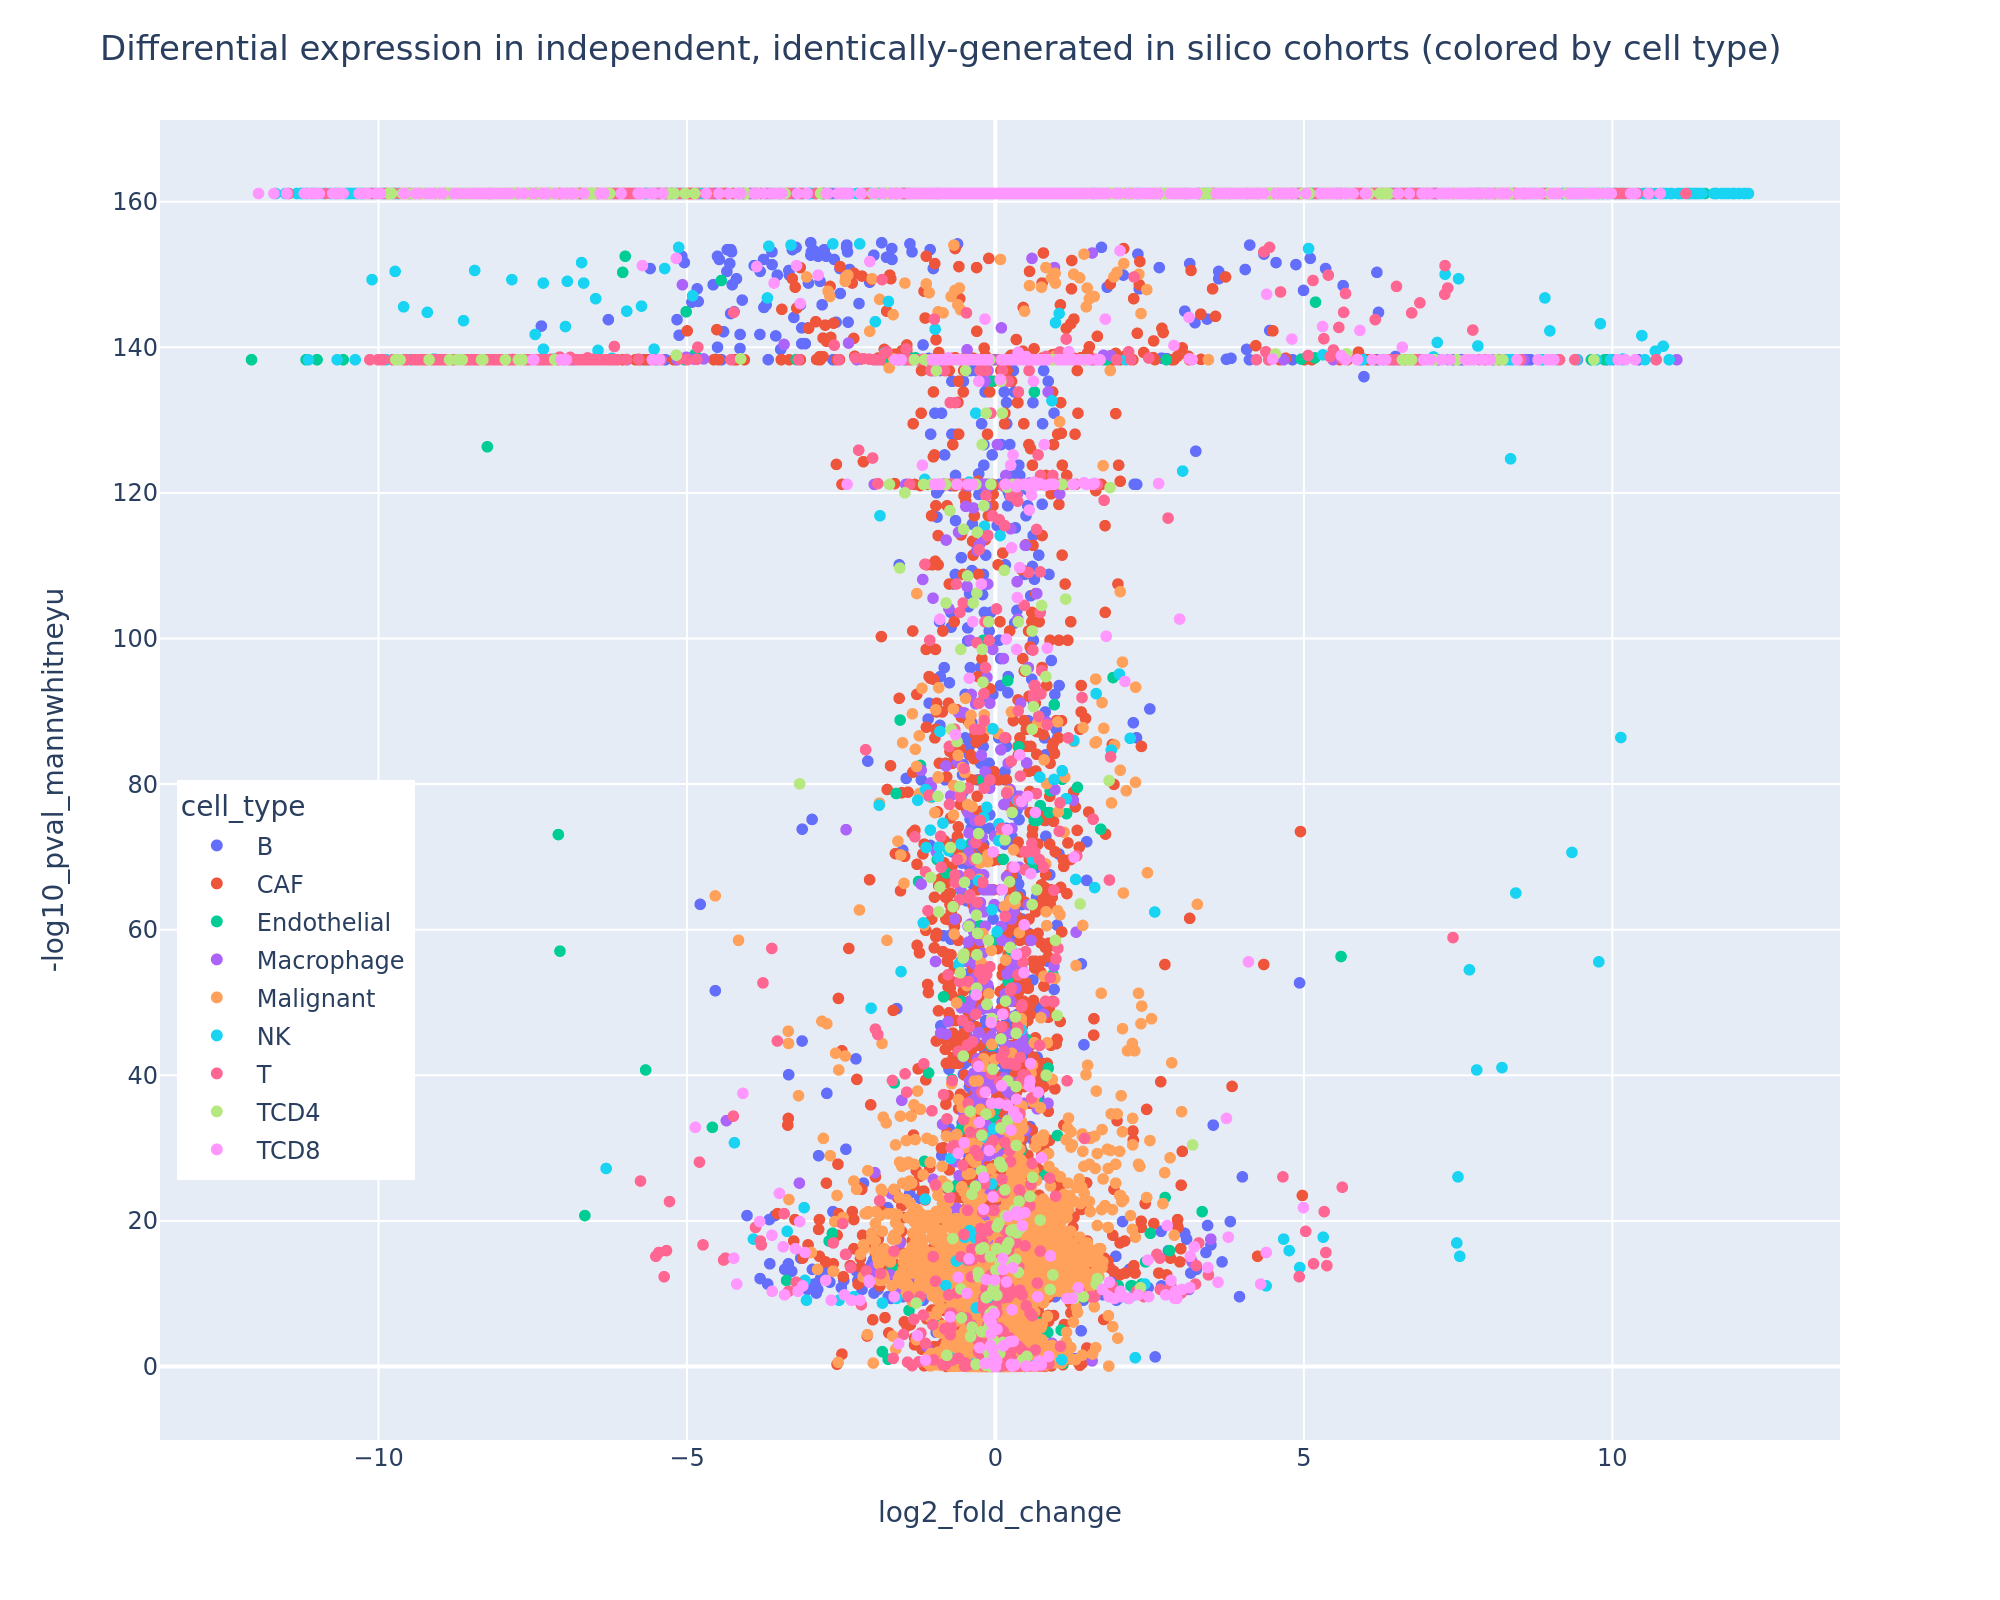

In [66]:
fig = px.scatter(
    results.reset_index(),
    x="log2_fold_change",
    y="-log10_pval_mannwhitneyu",
    color="cell_type",
)
fig.update_layout(
    title="Differential expression in independent, identically-generated in silico cohorts (colored by cell type)",
    legend=dict(yanchor="top", y=0.5, xanchor="left", x=0.01),
)
fig.show(renderer="png", width=1000, height=800, scale=2)

How to analyze differential expression, here?
* for each cell type, 


| Aspect | Differences |
| --- | --- |
| cell type composition | no difference |
| cell type-specific GEP | independently sampled, but with identical parameters and source scRNA-seq data |


In [24]:
!gsutil ls -Rlh "gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/"

gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/:

gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/0/:
114.17 MiB  2022-08-11T03:42:00Z  gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/0/pseudobulk_rnaseq.tsv

gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/0/data/:
114.17 MiB  2022-08-11T04:18:28Z  gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/0/data/bulkrnaseq.txt
463.55 KiB  2022-08-11T04:18:26Z  gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/0/data/sigmatrix.txt
  4.32 MiB  2022-08-11T04:18:26Z  gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/0/data/sourcegeps.txt

gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/0/outdir/:
 97.84 KiB  2022-08-11T04:18:25Z  gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/0/outdir/CIBERSORTxGEP_NA_Fractions-Adjusted.txt
  1.47 MiB  202

In [ ]:
df_gep = pd.read_csv(
    "gs://liulab/evaluating_cibersortx/identical_cohorts/2022-08-11_03:41:30/1/outdir/CIBERSORTxGEP_NA_GEPs.txt",
    sep="\t",
    index_col=0,
)
df_gep.index.sample(100)